# Préambule


In [1]:
import numpy as np
import math
import os
import matplotlib.pyplot as plt
import ipywidgets as widgets
%matplotlib widget

dossier = os.getcwd()

# Données pour la simulation

## Paramètres

In [2]:
temps_simu = 72 #temps en heures
pas_de_temps = 10 # pas de temps des entrées et sorties en minutes
nb_pdt = int(temps_simu*60/pas_de_temps)

## Constantes

In [3]:
Rho = 1000 # kg/m3
Cp = 4180 # J/(kg.K)
Nu = 0.000001
Tsol = 10  # °C

## Entrées de la simulation

In [34]:
"Débit en entrée"
Mtub_nom = 10  # kg/s       "Débit nominal
#option 1 : débit constant
Mtub = np.ones(nb_pdt)*Mtub_nom*0.8

#option 2 : débit variable (variation sinusoïdale)
#Mtub = [Mtub_nom*(5+3*math.sin(2*math.pi*t*10/(4*60)))/8 for t in range(nb_pdt)]

"Température de l'enau en entrée"
#Evolution sinusoïdale de la température
Tin = [50+2*math.sin(math.pi*t*10/(12*60)/2) for t in range(nb_pdt)]
Tout = np.zeros(nb_pdt)
Nout = np.zeros(nb_pdt)

## Caractéristiques de la canalisation

In [35]:
Long = 2000 # mètres
Lambda_iso = 0.02
V_lim = 2 # m/s

D_tube = np.round( (4 * Mtub_nom / (Rho * V_lim *math.pi))**(0.5), 2) # Calcul du diamètre des canalisation (m)
e_iso = 30.77 * D_tube**3 - 11.43 * D_tube**2 + 1.45 * D_tube

# Simulation

## Paramètres du schéma numérique

In [36]:
delta_t = 1 # pas de temps de calcul en minutes
N=int(Long/10)      #Nombre initial de volumes dans le tuyau
nb_dt = int(pas_de_temps/delta_t)
dt = 60*delta_t        #conversation pas de temps de calcul en secondes

## Initialisation du maillage du tuyau

In [37]:
L_vol = np.ones(N)*Long/N                                                          # longueur de chaque volume 
T_vol=np.ones(N)*70                                                                # Température de chaque volume
M_vol=np.ones(N)*Rho*Cp*math.pi * D_tube**2 / 4 * L_vol                            # Masse thermique de chaque volume 
R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)   # Résistance thermique de chaque volume

Tout[0] = T_vol[-1]
Nout[0] = N

## Calcul de la température en sortie

In [38]:
for t in range(nb_pdt-1):
    if Mtub[t]==0:
        Mtub[t]=0.0001
        
    for k in range(nb_dt):
        M_0 = np.array([Cp*Mtub[t]*dt])
        T_0 = np.array([Tin[t]])
        L_0 = np.array([Mtub[t]*dt/(Rho*math.pi*(D_tube/2)**2)])            

        T_vol2 = np.concatenate((T_0,T_vol*(1-dt/(R_vol*M_vol)) + dt/(R_vol*M_vol)*Tsol))
        L_vol2 = np.concatenate((L_0,L_vol))
        M_vol2 = np.concatenate((M_0,M_vol))

        L_vol3 = np.concatenate((L_vol2[np.cumsum(L_vol2)<Long],np.array([Long-np.sum(L_vol2[np.cumsum(L_vol2)<Long])])))
        T_vol3 = np.resize(T_vol2,np.shape(L_vol3))
        M_vol3 = Rho*Cp*math.pi * D_tube**2 / 4 *L_vol3
        M_vol22 = np.copy(M_vol3)
        M_vol22.resize(np.shape(M_vol2),refcheck=False)

        T_vol = T_vol3
        L_vol = L_vol3
        M_vol = M_vol3
        R_vol = np.log(( 2 * e_iso + D_tube) / D_tube)/(2 * math.pi *Lambda_iso * L_vol)
    
    Tout[t+1] = np.sum((M_vol2-M_vol22)*T_vol2)/np.sum(M_vol2-M_vol22)
    Nout[t+1] = np.shape(T_vol)[0]

# Sorties graphiques

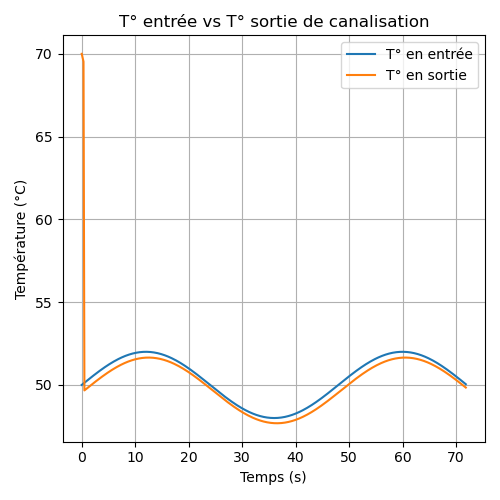

In [39]:
fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tin,label = 'T° en entrée')
axes.plot(np.arange(0,temps_simu,pas_de_temps/60),Tout, label = 'T° en sortie')
axes.legend()
axes.set(xlabel='Temps (s)', ylabel='Température (°C)',
       title='T° entrée vs T° sortie de canalisation')
axes.grid()

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'
os.chdir(dossier+'\\Résultats')
fig1.savefig("test_tuyau.png")
os.chdir(dossier)
plt.show()

In [40]:
np.mean(Tin[5:]-Tout[5:])

0.33514656200299786

In [42]:
(0.51-np.mean(Tin[5:]-Tout[5:]))/0.51

0.3428498784254944

In [4]:
Text = np.arange(-7,21,1)
Text

array([-7, -6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

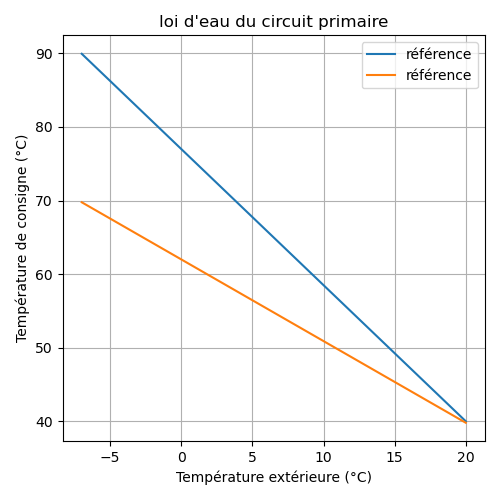

In [6]:
fig1, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

axes.plot(Text,77-1.85*Text,label = 'référence')
axes.plot(Text,62-1.11*Text,label = 'référence')
axes.legend()
axes.set(xlabel='Température extérieure (°C)', ylabel='Température de consigne (°C)',
       title='''loi d'eau du circuit primaire''')
axes.grid()

fig1.tight_layout()
fig1.canvas.toolbar_position = 'right'

plt.show()